In [1]:
from datasetcontroller.datacontroller import DataController
import tensorflow as tf
from nnmodules.unet import Unet_v2_1
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
import numpy as np

2023-06-20 08:23:46.246114: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 08:23:46.351482: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
BATCH_SIZE = 4
train_set_len = 100
shuffle_buffer_size = 100


def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(8, 8))
  # display_list = [test_input[0][0][:,:,:3], tar[0][:,:,0][::-1], prediction[0][::-1]]
  # title = ['Input', 'Ground Truth', 'Predicted Image']
  print(prediction.shape, tar.shape)
  display_list = [tar[0][::-1], prediction[0][::-1]]
  title = ['Ground Truth', 'Predicted Image']
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

* 데이터셋 정리

In [3]:
# set dataset path
path = os.path.join("/workspace")
data_path = os.path.join(path,'cmaqProjectdata')

# get controller
datacontroller = DataController(data_path = data_path)

# control matrix, smoke, cmaq 
control_matrix, smoke_arr, target_arr = datacontroller.get_yearly_dataset()

# 학습용셋
train_input = smoke_arr[:train_set_len]
test_input = smoke_arr[train_set_len:]

train_output = target_arr[:train_set_len]
test_output = target_arr[train_set_len:]

train_input_ds = tf.data.Dataset.from_tensor_slices(train_input)
train_target_ds = tf.data.Dataset.from_tensor_slices(train_output)

test_input_ds = tf.data.Dataset.from_tensor_slices(test_input)
test_target_ds = tf.data.Dataset.from_tensor_slices(test_output)


train_ds = tf.data.Dataset.zip((train_input_ds, train_target_ds)).batch(BATCH_SIZE).shuffle(shuffle_buffer_size)
test_ds = tf.data.Dataset.zip((test_input_ds, test_target_ds)).batch(BATCH_SIZE).shuffle(shuffle_buffer_size)


/usr/local/lib/python3.8/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


67 82


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3460: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/workspace/repos/cmaqProject/experiment/datasetcontroller/datacontroller.py:58: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:5179 +type=crs
Right CRS: EPSG:5179

  joined = gpd.sjoin(ctp_rvn_gpd, grid_data.to_crs(5179), op='contains')
2023-06-20 08:23:54.390600: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22201 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2023-06-20 08:23:54.391298: I tensorflow/core/common_runtime/gpu/gpu_device.cc:

* 모델

In [4]:
optimizer = tf.keras.optimizers.Adam(0.001)
unet = Unet_v2_1()
unet.compile()

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 unet=unet,
                                 )

# ####### 저장된 모델 있을 경우 ##########
# manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
# checkpoint.restore(manager.latest_checkpoint)


1


2023-06-20 08:23:55.419656: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101


(1, 82, 67, 1) (1, 82, 67, 1)


2023-06-20 08:23:57.052929: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


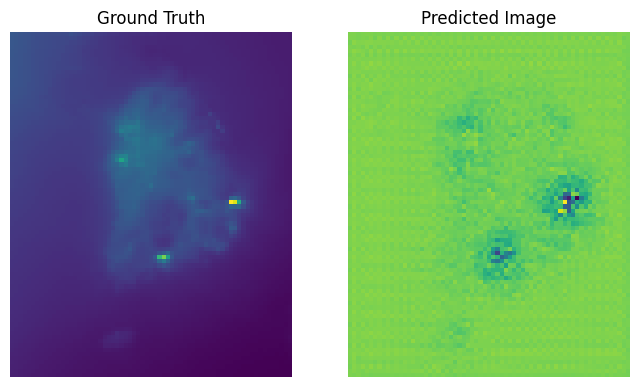

In [5]:

for batch in test_ds.take(1):
    print(1)
generate_images(unet, batch[0][0:1], batch[1][0:1])

* 학습

In [19]:
import datetime

init_lr = 0.0001
steps = 2000

In [20]:
@tf.function
def train_step(input, target,optimizer):
    with tf.GradientTape() as tape:
        output = unet(input, training=True)
        l1_loss = unet.lose_mse(target, output)
    gradients = tape.gradient(l1_loss,
                                            unet.trainable_variables)

    optimizer.apply_gradients(zip(gradients,
                                            unet.trainable_variables))
start = time.time()

for step, (input_arr, target) in train_ds.repeat().take(steps).enumerate():
  
  if (step) % 100 == 0:
    if step != 0:
      print(f'Time taken for 100 steps: {time.time()-start:.2f} sec\n')

    start = time.time()
    print(f"Step: {step}")

  train_step(input_arr, target,optimizer)

  if step % 1000 == 0:
    if step != 0:
      init_lr = init_lr*0.1
      optimizer = tf.keras.optimizers.Adam(init_lr)
      @tf.function
      def train_step(input_image, target,optimizer):
          with tf.GradientTape() as tape:
              output = unet(input_image, training=True)
              l1_loss = unet.lose_mse(target, output)
          gradients = tape.gradient(l1_loss,
                                                  unet.trainable_variables)

          optimizer.apply_gradients(zip(gradients,
                                                  unet.trainable_variables))

  # Training step
  if (step+1) % 10 == 0:
    print('.', end='', flush=True)


  # # Save (checkpoint) the model every 5k steps
  # if (step + 1) % 1000 == 0:
  #   checkpoint.save(file_prefix=checkpoint_prefix)

Step: 0
..........Time taken for 100 steps: 3.88 sec

Step: 100
..........Time taken for 100 steps: 3.03 sec

Step: 200
..........Time taken for 100 steps: 3.11 sec

Step: 300
..........Time taken for 100 steps: 3.11 sec

Step: 400
..........Time taken for 100 steps: 3.07 sec

Step: 500
..........Time taken for 100 steps: 3.09 sec

Step: 600
..........Time taken for 100 steps: 3.10 sec

Step: 700
..........Time taken for 100 steps: 3.10 sec

Step: 800
..........Time taken for 100 steps: 3.09 sec

Step: 900
..........Time taken for 100 steps: 3.01 sec

Step: 1000
..........Time taken for 100 steps: 7.81 sec

Step: 1100
..........Time taken for 100 steps: 3.09 sec

Step: 1200
..........Time taken for 100 steps: 3.09 sec

Step: 1300
..........Time taken for 100 steps: 3.02 sec

Step: 1400
..........Time taken for 100 steps: 3.06 sec

Step: 1500
..........Time taken for 100 steps: 3.00 sec

Step: 1600
..........Time taken for 100 steps: 3.03 sec

Step: 1700
..........Time taken for 100 ste

* 평가

3/3 [==============================] - 0s 22ms/step


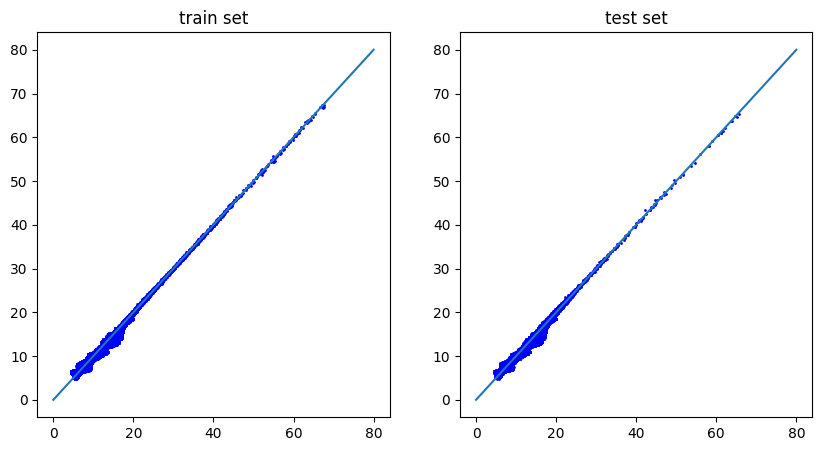

In [21]:
pred_train = unet.predict(train_input, batch_size = 8)
pred_test = unet.predict(test_input, batch_size = 8)

plt.figure(figsize=[10,5])

plt.subplot(1,2,1)
plt.title('train set')
plt.plot(pred_train.reshape(-1), train_output.reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])

plt.subplot(1,2,2)
plt.title('test set')
plt.plot(pred_test.reshape(-1), test_output.reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])

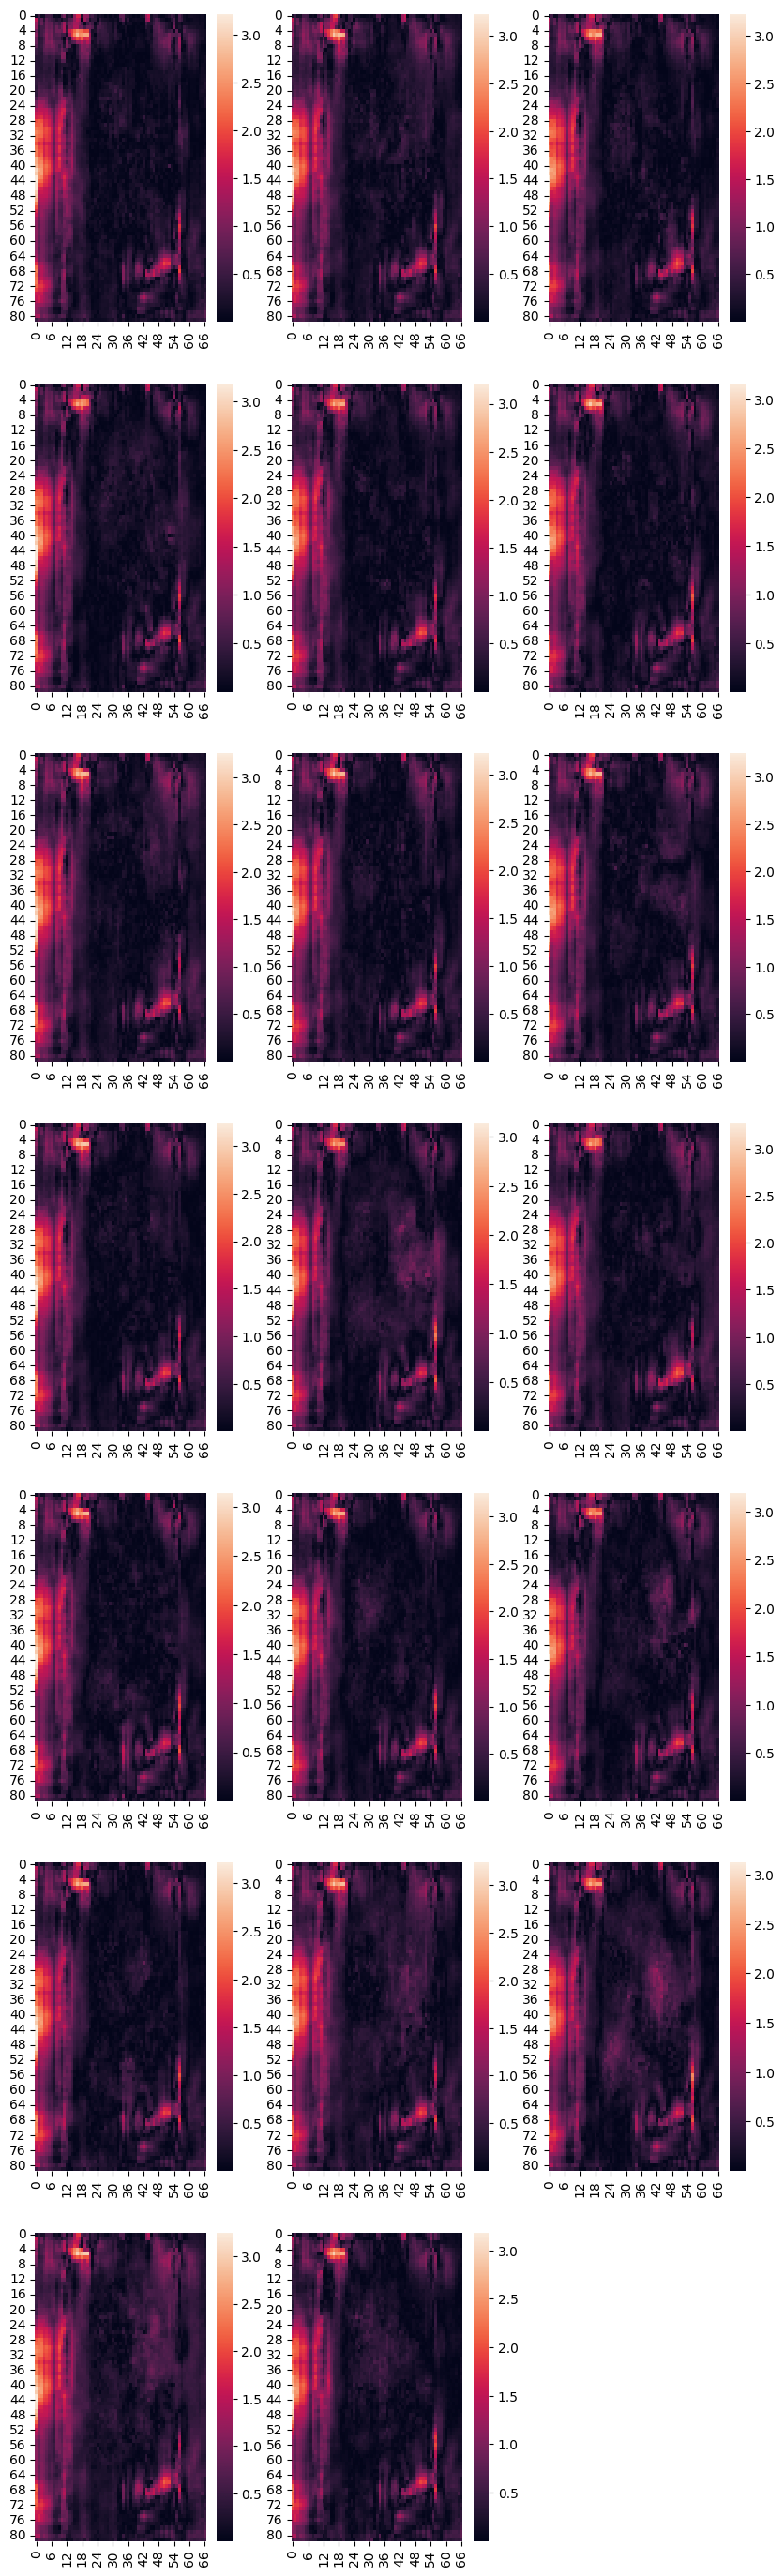

In [26]:
plt.figure(figsize = [10,35])
for i in range(len(pred_test)):
    plt.subplot(7,3,i+1)
    sns.heatmap(abs(pred_test[i][:,:,0][::-1] - test_output[i][:,:,0][::-1]))

In [23]:
def r_square(y_true, y_pred):
    SS_res = np.sum(np.square(y_true - y_pred))
    SS_tot = np.sum(np.square(y_true - np.mean(y_pred)))
    return (1-SS_res / SS_tot)
# In[]
def NME(y_true, y_pred):
    return np.sum( abs( (y_pred - y_true) / y_true ) ) / len(y_pred)

In [24]:
r_sq = []

for i in range(len(test_input)):
    r_sq.append(r_square(pred_test[i][::-1].reshape(-1), test_output[i][::-1].reshape(-1)))

print(np.mean(r_sq),np.std(r_sq),np.min(r_sq))

0.9774259303696453 0.0028058874069974327 0.9688834007829428


0.002945248293553157

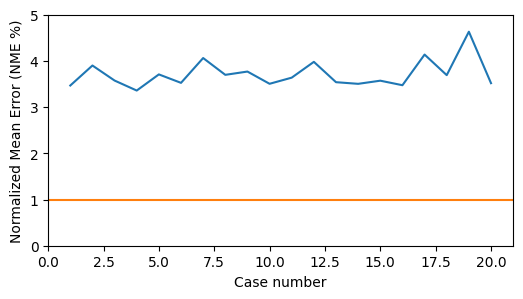

In [25]:
# In[]
result = []
                                                                                                                                                                                                                                                                                                                      
for i in range(len(test_input)):
    result.append(NME(pred_test[i][::-1].reshape(-1), test_output[i][::-1].reshape(-1)))
    
# In[]
plt.figure(figsize=(6,3))
plt.plot(np.arange(1,len(test_input)+1,1), np.array(result) * 100)
plt.xlim([0,len(test_input)+1])
plt.ylim([0,5])
plt.plot([0,len(test_input)+1],[1,1])
plt.xlabel('Case number') ; plt.ylabel('Normalized Mean Error (NME %)')

# In[]
np.max(result)
np.mean(result)
np.std(result)